## ML model for predicting bike rents, inlcuding pipeline
#### Kaggle competition: https://www.kaggle.com/competitions/bike-sharing-demand/overview
#### 02nd of Mai 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from matplotlib.ticker import StrMethodFormatter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import cross_val_score

In [2]:
# get data
df = pd.read_csv("train.csv", parse_dates=["datetime"])
real_test = pd.read_csv("test.csv", parse_dates=["datetime"])

In [3]:
# Extract hour, weekday and month from "datetime"
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday
df["mnth"] = df["datetime"].dt.month
real_test["hour"] = real_test["datetime"].dt.hour
real_test["weekday"] = real_test["datetime"].dt.weekday
real_test["mnth"] = real_test["datetime"].dt.month

In [4]:
# Split dataset
train, test = train_test_split(df, random_state=1)
train = train.sort_index()

<AxesSubplot:xlabel='humidity', ylabel='count'>

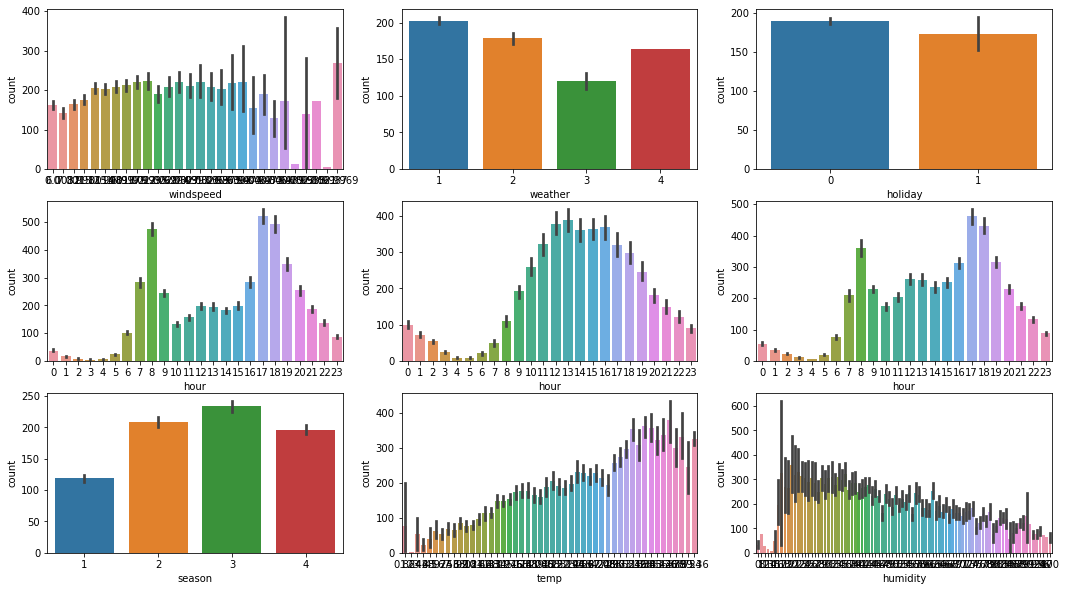

In [5]:
# Explore the data by plotting different combinations
fig, axs = plt.subplots(3,3, figsize=(18,10))
sns.barplot(ax=axs[1,0], y="count", x="hour", data=train[train["workingday"]==1])
sns.barplot(ax=axs[0,1],y="count", x="weather", data=train)
sns.barplot(ax=axs[0,2], y="count", x="holiday", data=train)
sns.barplot(ax=axs[2,1], y="count", x="temp", data=train)
sns.barplot(ax=axs[1,1], y="count", x="hour", data=train[train["workingday"]==0])
sns.barplot(ax=axs[1,2], y="count", x="hour", data=train)
sns.barplot(ax=axs[2,0], y="count", x="season", data=train)
sns.barplot(ax=axs[0,0], y="count", x="windspeed", data=train)
sns.barplot(ax=axs[2,2], y="count", x="humidity", data=train)

In [6]:
# Set the plot labeling and design
axs[0,0].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[0,0].xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axs[1,2].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[1,0].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[1,0].xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axs[1,0].set(xlabel="hour on workingday")
axs[1,1].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[1,1].xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axs[1,1].set(xlabel="hour not workingday")
axs[2,1].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[2,1].xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axs[2,2].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[2,2].xaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.1)
plt.show()
plt.close()

<Figure size 432x288 with 0 Axes>

In [7]:
# Define categorical and numerical features
categorical_features = ["weather", "season", "workingday", "hour"]
numerical_features = ["humidity", "windspeed", "atemp"]

In [8]:
# Run pipeline for transforming the data and training the ML model
categorical_transformer = Pipeline(steps=[
	("encoder", OneHotEncoder(handle_unknown="ignore"))])

numerical_transformer = Pipeline(steps=[
	("scaler", StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
	("categorcial", categorical_transformer, categorical_features),
	("numerical", numerical_transformer, numerical_features)])

pipeline = Pipeline(steps=[
	("preprocessor", preprocessor),
	("poly", PolynomialFeatures(degree=3, include_bias=False)),
	("regressor", Ridge(alpha=32))])

In [9]:
# Extract X and y from the datasets
X_train = train.loc[:, train.columns != "count"]
X_test = test.loc[:, test.columns != "count"]
y_train = np.log(train["count"])			# To avoid prediction of negative values, log of y is calculated
y_test = test["count"]

In [10]:
# Start the pipeline and predict the values for the test data
model = pipeline.fit(X_train, y_train)
pred = np.exp(model.predict(X_test))			# revert the log y valus by calculating the exponential value for predicted y
print(r2_score(y_test, pred))

0.8428891529283402


In [11]:
# Calculate the cross validation score
cross_r2_lin = cross_val_score(model,
	X_train, y_train,
	cv=5,
	scoring="r2",
	verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.730) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.874) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ................................ score: (test=0.814) total time=   0.3s
[CV] END ................................ score: (test=0.873) total time=   0.3s
[CV] END ................................ score: (test=0.861) total time=   0.3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


In [12]:
# Predict values for the kaggle test data
pred_real = np.exp(model.predict(real_test))
output = pd.DataFrame({'datetime': real_test.datetime, 'count': pred_real})
output.to_csv('submission bike 220505.csv', index=False)